### 初始化
定义工作目录 data_dir

In [1]:
import cooler
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from scipy.stats import mannwhitneyu



In [2]:
cool=cooler.Cooler('/cluster/home/futing/Project/GBM/HiC/02data/03cool_order/50000/A172_50000.cool')

In [3]:
pixels=cool.pixels()[:]

In [6]:
pixels['count'].shape

(25675499,)

In [2]:
data_dir = "/cluster/home/futing/Project/GBM/HiC/02data/03cool_KR/50000"
cooler_file_list = glob.glob(f"{data_dir}/*.cool", recursive=True)
cooler_file = "/cluster/home/futing/Project/GBM/HiC/02data/03cool_KR/50000/A172.50000.KR.cool"

### 对角线聚类 
文件太大了不行
来源于 cool_flat2.py

In [ ]:
diagonal_data = pd.read_csv("/cluster/home/futing/Project/GBM/HiC/02data/0350k/flattened_list2.csv",sep="\t")
diagonal_data=diagonal_data.T
diagonal.columns=['ts543','ts667','A172','U118','U343','U87','SW1088','G523','G583','G567','G176','G180','G182','G183','G238']
diagonal_data = diagonal_data.loc[(diagonal_data != 0).any(axis=1),:]
sample_similarity = diagonal_data.corr()

In [18]:
plt.figure(figsize=(8, 6))
g = sns.clustermap(sample_similarity, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5
                    ,dendrogram_ratio=(0.05, 0.05)   
                    ,cbar_pos=(-0.05, 0.2, 0.03, 0.45))
#plt.title('Insulation scores Heatmap', fontsize=16, pad=30,loc='center') 
plt.suptitle('Diagonal values Heatmap', fontsize=20, y=1.02) 
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=20)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=20)
plt.savefig('number_of_zeros_per_column.pdf')
# 显示图形
plt.show()

In [ ]:
count0=diagonal_data.apply(lambda x: (x == 0).sum())

### 全部拉直
一跑就崩溃

In [ ]:
import glob
import numpy as np
import cooler

data_dir = "/cluster/home/futing/Project/GBM/HiC/02data/0350k"
cooler_file_list = glob.glob(f"{data_dir}/**/*.ct.cool", recursive=True)

flattened_list = np.array([])

def get_matrix(cooler_file):
    c = cooler.Cooler(cooler_file)
    mat = c.matrix(balance=True)[:]
    half_matrix = np.triu(mat)
    flattened=half_matrix[np.triu_indices_from(mat)]
    return flattened

for cooler_file in cooler_file_list:
    flattened_list = np.hstack((flattened_list, get_matrix(cooler_file)))


### 查看测序深度

文件来源于hicInfo

In [37]:
#hicInfo=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/02data/0350k/hicInfo.csv',sep='\t')
hicInfo=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/02data/0350k/hicInfo_kr.txt',sep='\t')

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

In [39]:
hicInfo['element']=hicInfo['element'].str.replace(',', '').astype(int)
hicInfo['log']=np.log(hicInfo['element'])

In [41]:
import itertools
hicInfo['group'] = list(itertools.repeat('Our', 2)) + \
                   list(itertools.repeat('Xu', 5)) + \
                   list(itertools.repeat('Johnson', 3)) + \
                   list(itertools.repeat('Harewood', 5))


/cluster/home/futing/anaconda3/envs/hic/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/futing/anaconda3/envs/hic/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/futing/anaconda3/envs/hic/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_

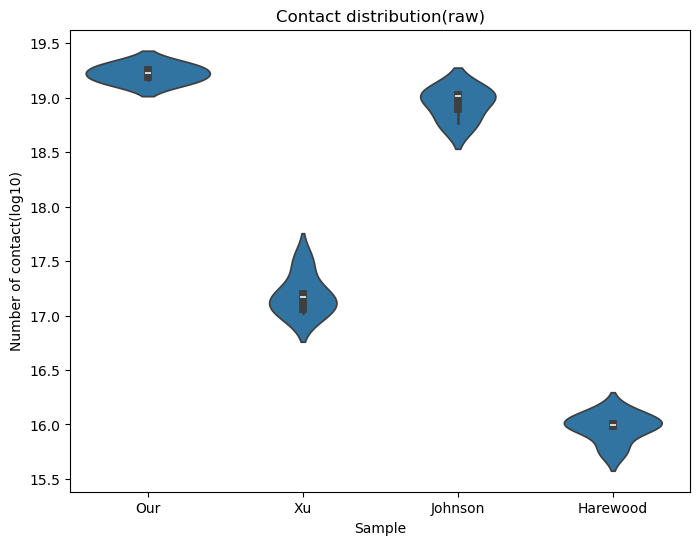

In [44]:
plt.figure(figsize=(8, 6))
sns.violinplot(x='group', y='log', data=hicInfo)
plt.xlabel('Sample')
plt.ylabel('Number of contact(log10)')
plt.title('Contact distribution(raw)')
plt.show()


### E-P 聚类

#### 获取 E-P bin_id and contact

In [2]:
RNA=pd.read_csv('/cluster/home/futing/Project/GBM/RNA_ChIP/results_match_all.csv')
gene_bed = pd.read_csv("/cluster/home/futing/ref_genome/hg38_gencode/humanGTF",sep="\t",header=None)
gene_bed.iloc[:,2] = gene_bed.iloc[:,2].str.split('.',expand=True)[0]
enhancer=pd.read_csv('/cluster/home/futing/Project/GBM/RNA_ChIP/GSC_vs_DGC_deseq2_sig_match_GSCup.bed',sep='\t',header=None)

In [3]:
#获取RNA差异基因，及其bed文件，重命名chr,start,end，并加上染色体前缀
RNA_sig=RNA[RNA['change']!='Stable']
RNA_sig_bed=gene_bed.loc[gene_bed[0].isin(RNA_sig['gene_name']),[3,4,5]]
RNA_sig_bed=RNA_sig_bed.rename(columns={3:'chr',4:'start',5:'end'})
RNA_sig_bed=RNA_sig_bed[~RNA_sig_bed['chr'].str.isalpha()]

In [4]:
# 获取enhancer的bed文件，重命名chr,start,end，并加上染色体前缀
enhancer=enhancer[[0,1,2]]
enhancer=enhancer.rename(columns={0:'chr',1:'start',2:'end'})
enhancer=enhancer[~enhancer['chr'].str.isalpha()]

In [8]:
# 读取存好的文件，文件来源于上面的处理
enhancer=pd.read_csv(f'{data_dir}/EP/enhancer.bed',sep='\t',usecols=[1,2,3])
RNA_sig_bed=pd.read_csv(f'{data_dir}/EP/gene.bed',sep='\t',usecols=[1,2,3])

In [59]:
from intervaltree import Interval, IntervalTree
def build_interval_tree(bin_matrix):
    tree = IntervalTree()
    for i, row in bin_matrix.iterrows():
        # Interval 的范围是左闭右开，这与题设匹配
        tree[row['start']:row['end']] = i  # 存储 bin_matrix 的索引作为值
    return tree
bin_matrix = cooler.Cooler(cooler_file_list[0]).bins()[:]  # 读取 bin_matrix
tree = build_interval_tree(bin_matrix)

def get_bins(chr,pos,tree=tree):
    result = tree[pos]
    chrom= int(chr.split('chr')[1]) - 1
    return sorted(list(result))[chrom].data
# 02 定义查找 'count' 值的函数
def find_count(bin1_id, bin2_id):
    if pd.isna(bin1_id) or pd.isna(bin2_id):
        return None
    if bin1_id > bin2_id:
        bin1_id, bin2_id = bin2_id, bin1_id
    key = (bin1_id, bin2_id)
    return pixels.at[key, 'count'] if key in pixels.index else None

def find_count_matrix(bin1_id,bin2_id):
    return matrix[bin1_id,bin2_id]

In [ ]:
# 01 寻找bin_id，并且返回两两组合
import itertools
RNA_sig_bed['bin_id']=RNA_sig_bed.apply(lambda x: get_bins(x['chr'],(x['start']+x['end'])/2),axis=1)
enhancer['bin_id']=enhancer.apply(lambda x: get_bins(x['chr'],(x['start']+x['end'])/2),axis=1)
# 两两组合
E_P= list(itertools.product(RNA_sig_bed['bin_id'], enhancer['bin_id']))
EP = pd.DataFrame(E_P, columns=['RNA', 'enhancer'])

In [25]:
print(f'RNA is {RNA_sig_bed.shape[0]}, enhancer is {enhancer.shape[0]}, E-P is {EP.shape[0]}')

RNA is 1148, enhancer is 3114, E-P is 3574872


In [32]:
# 02 计算每个组合的 count 值

data_dir = "/cluster/home/futing/Project/GBM/HiC/02data/0350k"
cooler_file_list = glob.glob(f"{data_dir}/**/*.ct.cool", recursive=True)

for cooler_file in cooler_file_list:
    print(cooler_file)

    file=cooler_file.split('/')[-1].split('.')[0]
    c = cooler.Cooler(cooler_file)
    
    pixels=c.pixels()[:]
    pixels.set_index(['bin1_id', 'bin2_id'], inplace=True)

    print('Set index done..')
    EP[file] = EP.apply(lambda row: find_count(row['RNA'], row['enhancer']), axis=1)

    
    

/cluster/home/futing/Project/GBM/HiC/02data/0350k/01our/ts543_50k.kr.ct.cool
Set index done..
/cluster/home/futing/Project/GBM/HiC/02data/0350k/01our/ts667_50k.kr.ct.cool
Set index done..
/cluster/home/futing/Project/GBM/HiC/02data/0350k/02xu/A172_50k.kr.ct.cool
Set index done..
/cluster/home/futing/Project/GBM/HiC/02data/0350k/02xu/U118_50k.kr.ct.cool
Set index done..
/cluster/home/futing/Project/GBM/HiC/02data/0350k/02xu/U343_50k.kr.ct.cool
Set index done..
/cluster/home/futing/Project/GBM/HiC/02data/0350k/02xu/U87_50k.kr.ct.cool
Set index done..
/cluster/home/futing/Project/GBM/HiC/02data/0350k/02xu/SW1088_50k.kr.ct.cool
Set index done..
/cluster/home/futing/Project/GBM/HiC/02data/0350k/03Johnson/G523_50k.kr.ct.cool
Set index done..
/cluster/home/futing/Project/GBM/HiC/02data/0350k/03Johnson/GB583_50k.kr.ct.cool
Set index done..
/cluster/home/futing/Project/GBM/HiC/02data/0350k/03Johnson/GB567_50k.kr.ct.cool
Set index done..
/cluster/home/futing/Project/GBM/HiC/02data/0350k/04harewo

In [88]:
# 03 用 balance 的结果
data_dir = "/cluster/home/futing/Project/GBM/HiC/02data/0350k"
cooler_kr_file_list = glob.glob(f"{data_dir}/**/*.kr.cool", recursive=True)
EP_kr=EP.iloc[:,0:2]

for cooler_file in cooler_kr_file_list:
    print(cooler_file)

    file=cooler_file.split('/')[-1].split('.')[0]
    c = cooler.Cooler(cooler_file)
    matrix=c.matrix(balance=True)[:]
    EP_kr[file] = EP_kr.apply(lambda row: matrix[int(row['RNA']), int(row['enhancer'])], axis=1)

/cluster/home/futing/Project/GBM/HiC/02data/0350k/01our/ts543_50k.kr.cool
/cluster/home/futing/Project/GBM/HiC/02data/0350k/01our/ts667_50k.kr.cool
/cluster/home/futing/Project/GBM/HiC/02data/0350k/02xu/A172_50k.kr.cool
/cluster/home/futing/Project/GBM/HiC/02data/0350k/02xu/U118_50k.kr.cool
/cluster/home/futing/Project/GBM/HiC/02data/0350k/02xu/U343_50k.kr.cool
/cluster/home/futing/Project/GBM/HiC/02data/0350k/02xu/U87_50k.kr.cool
/cluster/home/futing/Project/GBM/HiC/02data/0350k/02xu/SW1088_50k.kr.cool
/cluster/home/futing/Project/GBM/HiC/02data/0350k/03Johnson/G523_50k.kr.cool
/cluster/home/futing/Project/GBM/HiC/02data/0350k/03Johnson/G567_50k.kr.cool
/cluster/home/futing/Project/GBM/HiC/02data/0350k/03Johnson/G583_50k.kr.cool
/cluster/home/futing/Project/GBM/HiC/02data/0350k/04harewood/GB176_50k.kr.cool
/cluster/home/futing/Project/GBM/HiC/02data/0350k/04harewood/GB180_50k.kr.cool
/cluster/home/futing/Project/GBM/HiC/02data/0350k/04harewood/GB182_50k.kr.cool
/cluster/home/futing/Pr

In [89]:
# 看一看每列0个数
EP_kr=EP_kr.fillna(0)
EP_kr.apply(lambda x: (x ==0).sum(),axis=0)

RNA                 0
enhancer            0
ts543_50k     3042915
ts667_50k     3053198
A172_50k      3502629
U118_50k      3486927
U343_50k      3478163
U87_50k       3511427
SW1088_50k    3469170
G523_50k      2982561
G567_50k      3143786
G583_50k      2974406
GB176_50k     3554916
GB180_50k     3553162
GB182_50k     3556109
GB183_50k     3561168
GB238_50k     3555518
dtype: int64

In [90]:
EP_kr.to_csv('EP_kr.csv',index=False)

#### 过滤，直接cor

In [60]:
#EP.to_csv('EP.csv')
EP=pd.read_csv(f'{data_dir}/EP/EP.csv')
EP=EP.drop(columns=['Unnamed: 0'])

In [3]:
#  去掉第二列以后全部是0的行，去掉RNA和enhancer列，作为index
EP_fil=EP.loc[(EP.iloc[:,2:] != 0).any(axis=1),:]
EP_fil.index=EP_fil['RNA'].astype(str)+'_'+EP_fil['enhancer'].astype(str)
EP_fil=EP_fil.drop(columns=['RNA','enhancer'])
EP_fil=EP_fil.rename(columns={'GB583_50k' : 'G583_50k','GB567_50k':'G567_50k'})

In [4]:
# 归一化矩阵
EP_fil=EP_fil.apply(lambda x: np.log(x+1))

In [41]:
#去掉0个数大于4的行
EP_fil_ss=EP_fil.loc[(EP_fil == 0).sum(axis=1) <=4,: ]
EP_fil_ss.apply(lambda x: x==0).sum(axis=0)

ts543_50k       47
ts667_50k       41
A172_50k       310
U118_50k       221
U343_50k       192
U87_50k        317
SW1088_50k     244
G523_50k       100
G583_50k       130
G567_50k       129
GB176_50k     2409
GB180_50k     2623
GB182_50k     2379
GB183_50k     2977
GB238_50k     2413
dtype: int64

<Figure size 1000x600 with 0 Axes>

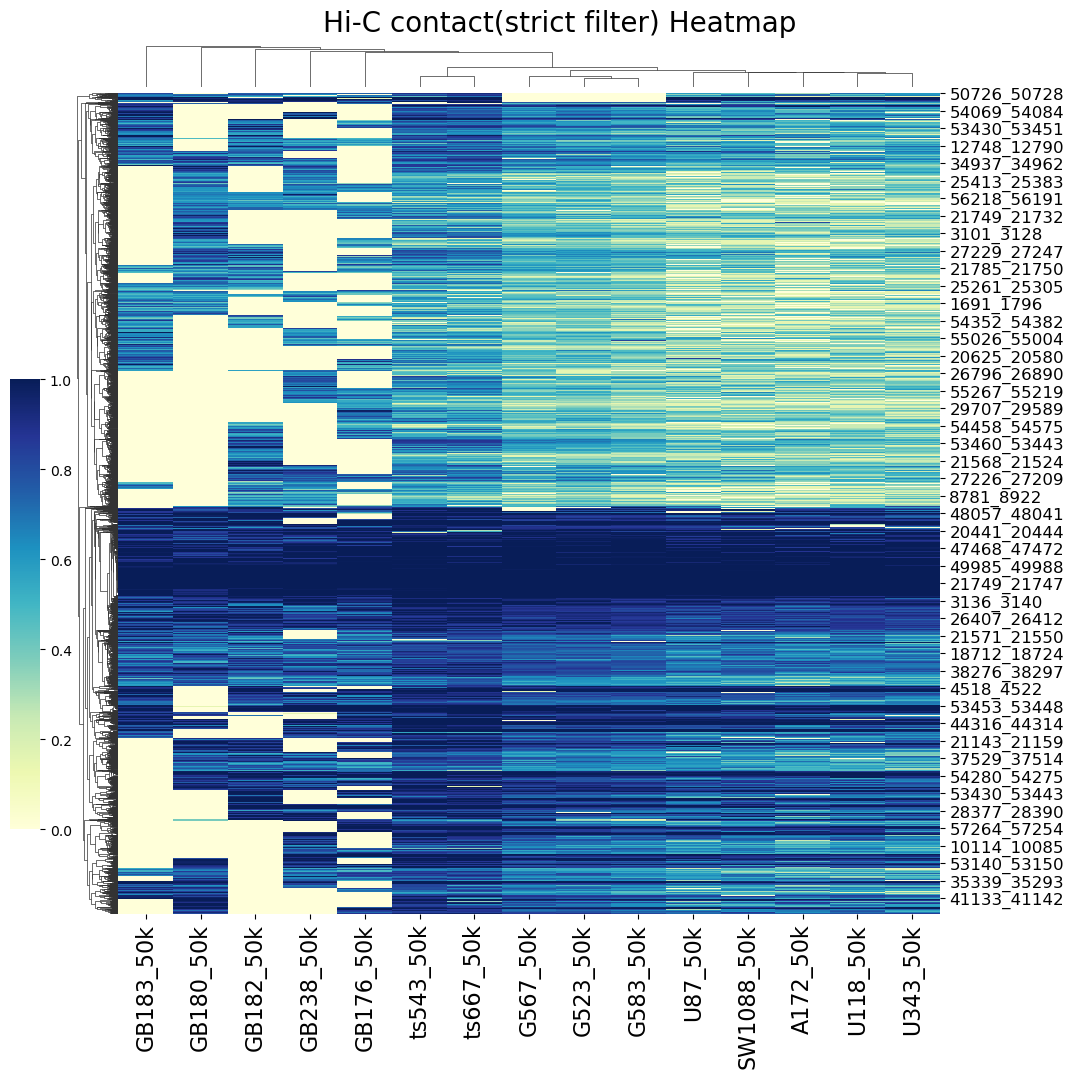

In [43]:
plt.figure(figsize=(10, 6))

g=sns.clustermap(EP_fil_ss, cmap='YlGnBu',dendrogram_ratio=(0.05, 0.05) 
                    , metric='euclidean', method='average', standard_scale=1
                    ,cbar_pos=(-0.05, 0.2, 0.03, 0.45)
                    ) 
# 添加标题和标签
plt.suptitle('Hi-C contact(strict filter)', fontsize=20, y=1.02)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=16)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=12)
plt.show()

<Figure size 800x600 with 0 Axes>

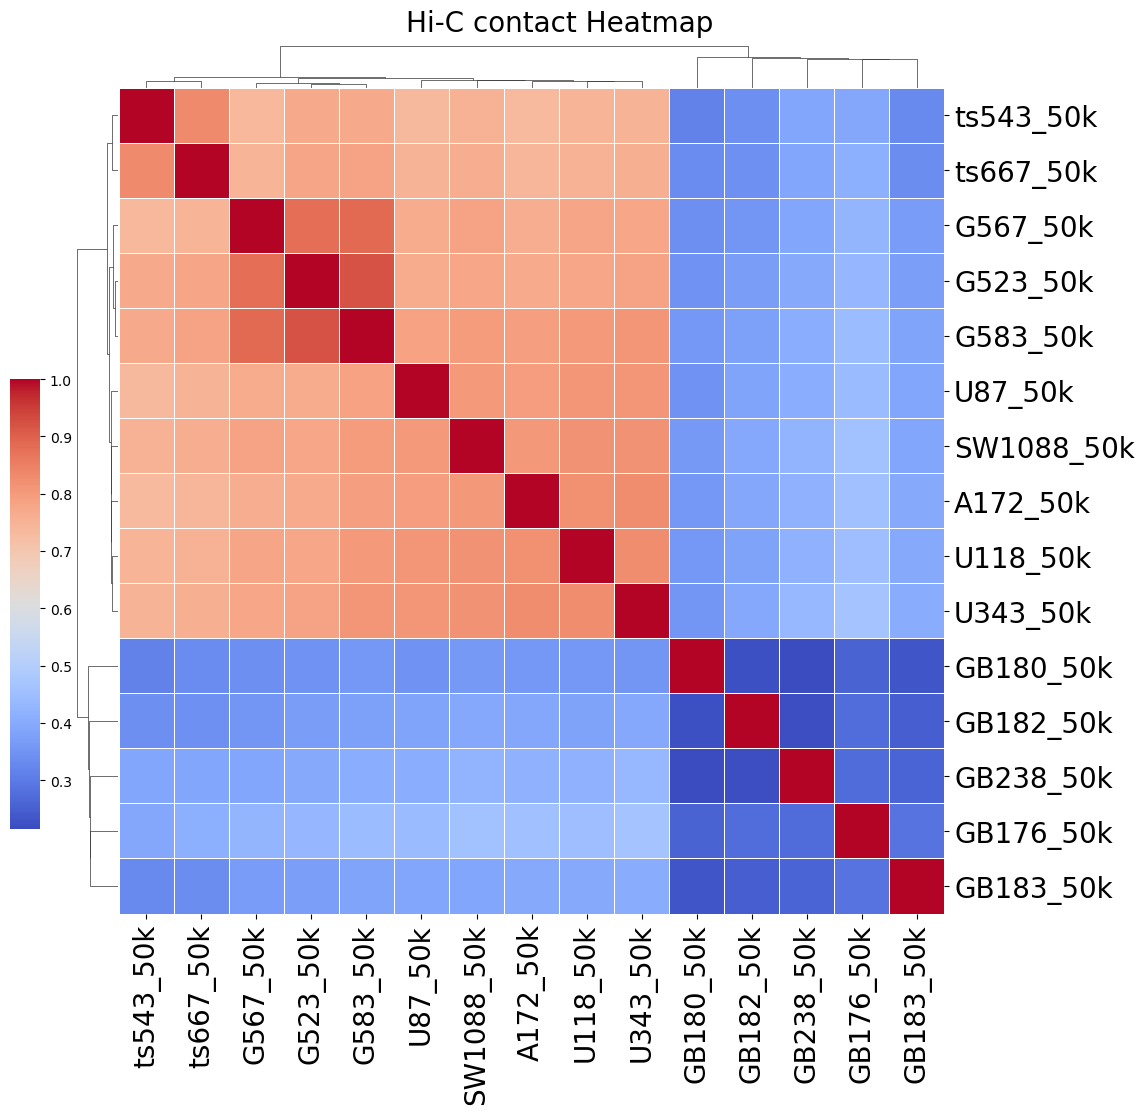

In [44]:
# 计算样本之间的相关系数作为相似度
sample_similarity = EP_fil_ss.corr()

plt.figure(figsize=(8, 6))
g = sns.clustermap(sample_similarity, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5
                    ,dendrogram_ratio=(0.05, 0.05)   
                    ,cbar_pos=(-0.05, 0.2, 0.03, 0.45))
#plt.title('Insulation scores Heatmap', fontsize=16, pad=30,loc='center') 
plt.suptitle('Hi-C contact Heatmap', fontsize=20, y=1.02) 
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=20)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=20)
# 显示图形
plt.show()


#### kmeans 聚类

In [46]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca = PCA(n_components=10)  # 指定降维到2维
matrix= EP_fil_ss.values.T
X = pca.fit_transform(matrix)

# 定义KMeans模型，指定聚类数量为2
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X)
# 获取聚类中心
centroids = kmeans.cluster_centers_
# 获取每个点所属的簇
clust_labels = kmeans.labels_

# 输出聚类结果
print("Cluster centers:\n", centroids)
print("Labels:\n", clust_labels)


/cluster/home/futing/anaconda3/envs/hic/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster centers:
 [[-6.79924432e+00  4.00424461e+00  1.21697880e+00  5.42087976e+00
   2.49246706e+00 -1.04248914e+00  9.42574278e-02 -1.30468952e-02
  -1.37985317e-02  1.07271048e-02]
 [ 9.51894204e+01 -5.60594245e+01 -1.70377032e+01 -7.58923167e+01
  -3.48945388e+01  1.45948480e+01 -1.31960399e+00  1.82656533e-01
   1.93179444e-01 -1.50179468e-01]]
Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]


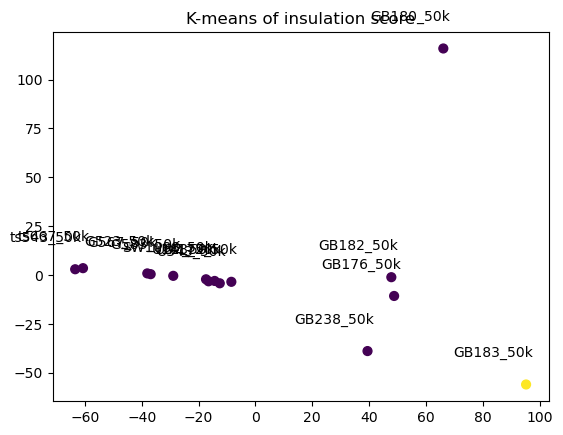

In [47]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

labels=list(EP_fil.columns)
# 标签编码
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# 绘制散点图
plt.scatter(X[:, 0], X[:, 1], c=clust_labels, s=40, cmap='viridis')
''''''
for i, label in enumerate(labels):
    # 选择需要标记的点
    plt.annotate(label, (X[i][0], X[i][1]), textcoords="offset points", xytext=(5,20), ha='right')
plt.title("K-means of insulation score")
plt.show()

### insulation 聚类

#### read insulation scores and filter

In [10]:
stem=pd.read_csv("/cluster/home/futing/Project/GBM/HiC/02data/0350k/insulation/stem_insulation.txt",sep="\t")
nonstem=pd.read_csv("/cluster/home/futing/Project/GBM/HiC/02data/0350k/insulation/nonstem_insulation.txt",sep="\t")
id=stem.iloc[:,0:3]
stem=stem.iloc[:,3:]
nonstem=nonstem.iloc[:,3:] 

In [ ]:
#stem_bound.columns=['G523','G567','G583','ts543','ts667']
stem.columns=['G523','G567','G583','ts543','ts667']
nonstem.columns=['A172','GB176','GB180','GB182','GB183','GB238','SW1088','U118','U343','U87']

In [ ]:
all=pd.concat([stem,nonstem],axis=1)
filcon=(all==0).sum(axis=1) <= 8 # 去掉一半为0的行
all_fil=all.loc[filcon,:] #去掉一半为0的行
all_fi2=all.loc[(all != 0).any(axis=1),:] #去掉全为0的行

#### get sig features between stem and unknown
wilcoxon 秩和检验

In [ ]:
data1=stem.loc[all_fil.index,:].T
data2=nonstem.loc[all_fil.index,:].T
significant_features = []
p_values = []

# 对每个特征进行Wilcoxon秩和检验
for i in range(data1.shape[1]):
    feature1 = data1.iloc[:, i]
    feature2 = data2.iloc[:, i]
    stat, p_value = mannwhitneyu(feature1, feature2)
    if p_value < 0.05:  # 使用显著性水平0.05
        significant_features.append(i)
        p_values.append(p_value)

# 输出结果
print("显著差异的特征索引：", significant_features)
print("对应的p值：", p_values)

显著差异的特征索引： [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 69, 73, 75, 161, 162, 163, 164, 165, 166, 167, 168, 170, 171, 192, 193, 194, 197, 198, 199, 200, 201, 202, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 347, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 474, 501, 502, 503, 504, 505, 506, 507, 508, 562, 563, 564, 565, 566, 567, 568, 570, 648, 651, 652, 653, 654, 656, 661, 701, 702, 703, 704, 872, 873, 874, 875, 934, 936, 941, 942, 943, 944, 945, 946, 947, 948, 993, 994, 995, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1171, 1201, 1202, 1203, 1204, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1321, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1443, 1444, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 14

In [ ]:
all_sig_U=all_fil.iloc[significant_features,:].T
all_sig_U.T.head()

,G523,G567,G583,ts543,ts667,A172,GB176,GB180,GB182,GB183,GB238,SW1088,U118,U343,U87
16,-1.484269,-1.193155,-0.660383,-1.426398,-1.423592,-2.228293,-5.862947,-3.594150,-6.132371,-4.957450,-4.065012,-2.003247,-1.741638,-1.872590,-2.513340
17,-1.175262,-0.937204,-0.447496,-0.945765,-0.989215,-1.586285,-4.277985,-3.038334,-3.839589,-4.957450,-3.065012,-1.420523,-1.198883,-1.610399,-1.688824
18,-0.851815,-0.735837,-0.303698,-0.600213,-0.644225,-1.090380,-3.055592,-2.949525,-3.345775,-3.372488,-2.495764,-1.042356,-0.862197,-1.278941,-1.155848
19,-0.569902,-0.555230,-0.185798,-0.315505,-0.425573,-0.822577,-2.693022,-2.949525,-2.686115,-2.957450,-2.170679,-0.685014,-0.612181,-0.932415,-0.868399
20,-0.375524,-0.394737,-0.075527,-0.110920,-0.198185,-0.579086,-1.956057,-2.437107,-2.335358,-2.218682,-1.681653,-0.487877,-0.418189,-0.674737,-0.603000


In [ ]:
all_sig_U.T.to_csv("/cluster/home/futing/Project/GBM/HiC/02data/0350k/insulation/all_sig_U.txt",sep="\t",header=True)
#all_sig_U=pd.read_csv("/cluster/home/futing/Project/GBM/HiC/02data/0350k/insulation/all_sig_U.txt",sep="\t")

#### PCA and K-means

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)  # 指定降维到2维
# all_sig_U 行是样本list，列是特征
projected_data = pca.fit_transform(all_sig_U)

In [ ]:
import numpy as np

def kmeans(data, k, max_iters=100):
    # 1. 初始化聚类中心
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]
    
    for _ in range(max_iters):
        # 2. 计算每个数据点到每个聚类中心的距离
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        
        # 3. 分配数据点到最近的聚类中心
        labels = np.argmin(distances, axis=1)
        
        # 4. 更新聚类中心
        new_centroids = np.array([data[labels == i].mean(0) for i in range(k)])
        
        # 5. 检查是否收敛
        if np.all(new_centroids == centroids):
            break
        
        centroids = new_centroids
    
    return centroids, labels

np.random.seed(0)
#X = all_sig_U.T
# X 行是样本，列是特征
X = projected_data
centroids, clust_labels = kmeans(X, k=2)

# 输出结果
print("聚类标签：", labels)
print("聚类中心：", centroids)


聚类标签： [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
聚类中心： [[ 2.88850151e+01  2.93743162e+00 -5.70249829e+00  3.97157975e-01
   1.31106990e-01  4.97514932e-01 -3.02151333e-02  3.09843934e-01
  -2.21588524e-01  5.06745818e-02]
 [-1.44425076e+01 -1.46871581e+00  2.85124915e+00 -1.98578988e-01
  -6.55534948e-02 -2.48757466e-01  1.51075667e-02 -1.54921967e-01
   1.10794262e-01 -2.53372909e-02]]


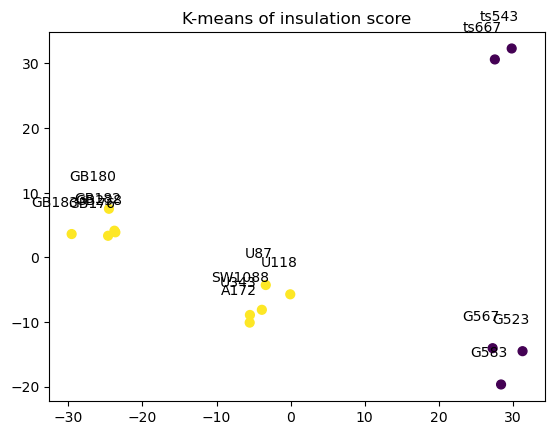

In [ ]:
from sklearn.preprocessing import LabelEncoder
labels=list(all_sig_U.index)
# 标签编码
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# 绘制散点图
plt.scatter(X[:, 0], X[:, 1], c=clust_labels, s=40, cmap='viridis')
''''''
for i, label in enumerate(labels):
    # 选择需要标记的点
    plt.annotate(label, (X[i][0], X[i][1]), textcoords="offset points", xytext=(5,20), ha='right')
plt.title("K-means of insulation score")
plt.show()

In [ ]:

def pca(X, num_components):
    # 1. 标准化数据
    X_normalized = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    
    # 2. 计算协方差矩阵
    covariance_matrix = np.cov(X_normalized, rowvar=False)
    
    # 3. 计算特征值和特征向量
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    
    # 4. 选择前num_components个特征向量
    top_eigenvectors = eigenvectors[:, :num_components]
    
    # 5. 投影数据到低维空间
    projected_data = np.dot(X_normalized, top_eigenvectors)
    
    return projected_data

In [ ]:
X = pca(X, num_components=15)

#### cor heatmap of sig insulation score

<Figure size 800x600 with 0 Axes>

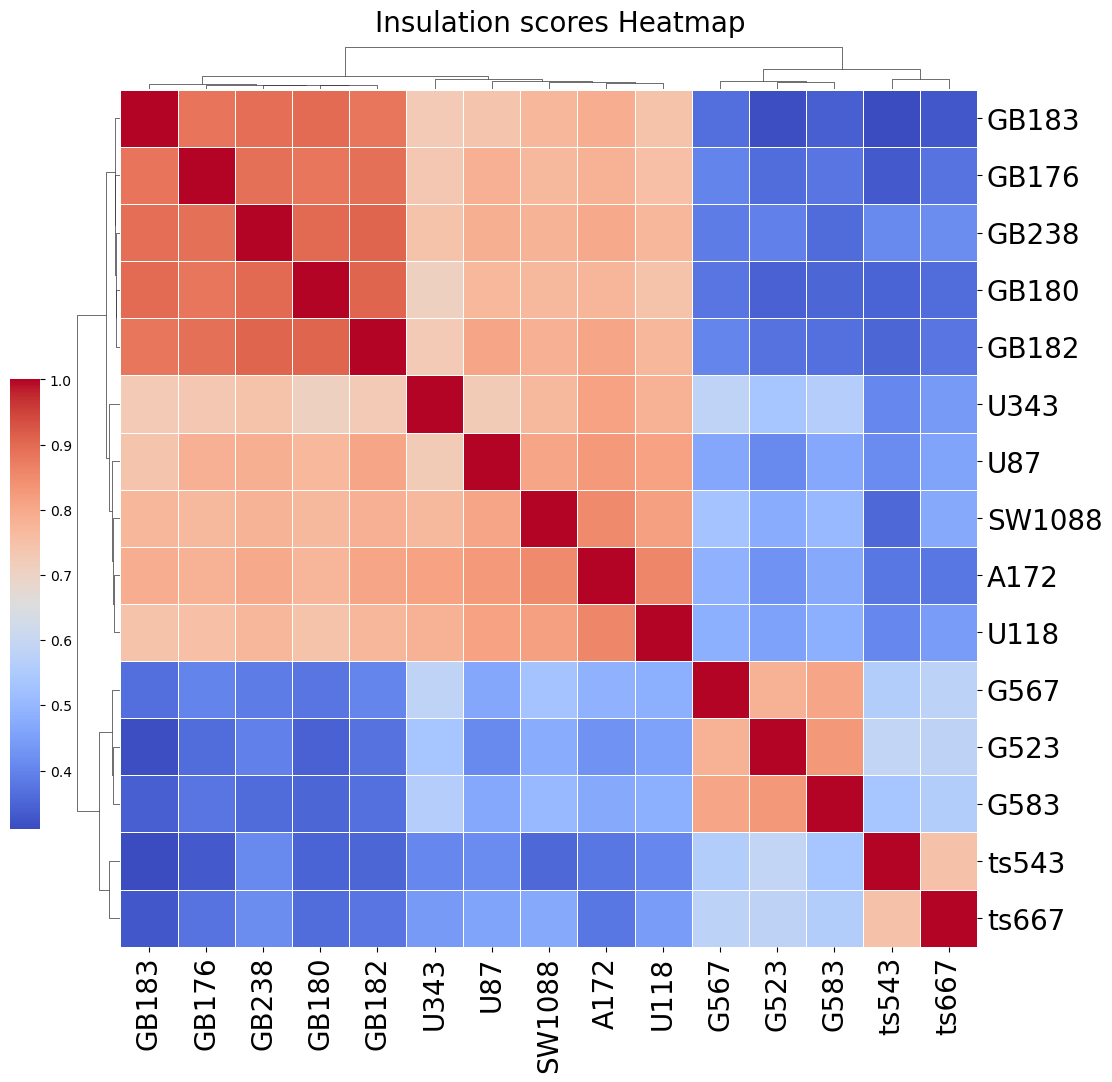

In [ ]:
# 计算样本之间的相关系数作为相似度
sample_similarity = all_sig_U.corr()

plt.figure(figsize=(8, 6))
g = sns.clustermap(sample_similarity, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5
                    ,dendrogram_ratio=(0.05, 0.05)   
                    ,cbar_pos=(-0.05, 0.2, 0.03, 0.45))
#plt.title('Insulation scores Heatmap', fontsize=16, pad=30,loc='center') 
plt.suptitle('Insulation scores Heatmap', fontsize=20, y=1.02) 
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=20)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=20)
# 显示图形
plt.show()


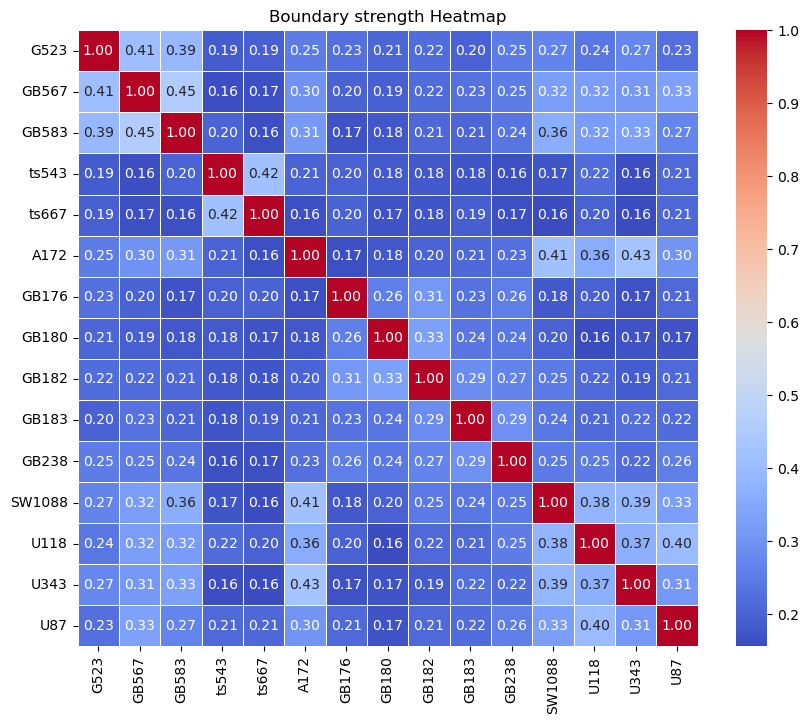

In [ ]:
#all_bound=pd.concat([stem_bound,nonstem_bound],axis=1)
all_bound_fil=all_bound.loc[(all_bound != 0).any(axis=1),:]
all_bound_similarity = all_bound_fil.corr()

# 绘制热图
plt.figure(figsize=(10, 8))
sns.heatmap(all_bound_similarity, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Boundary strength Heatmap')
plt.show()


### 未补齐的insulation scores

In [ ]:
old_nonstem_insul = pd.read_csv("/cluster/home/futing/Project/GBM/HiC/09insulation/cooltools_insulation/nonstem_insulation.txt",sep='\t')
old_stem_insul = pd.read_csv("/cluster/home/futing/Project/GBM/HiC/09insulation/cooltools_insulation/stem_insulation.txt",sep='\t')
id_old=old_stem_insul.iloc[:,0:3]
old_stem_insul=old_stem_insul.iloc[:,3:]
old_nonstem_insul=old_nonstem_insul.iloc[:,3:]

<Figure size 800x600 with 0 Axes>

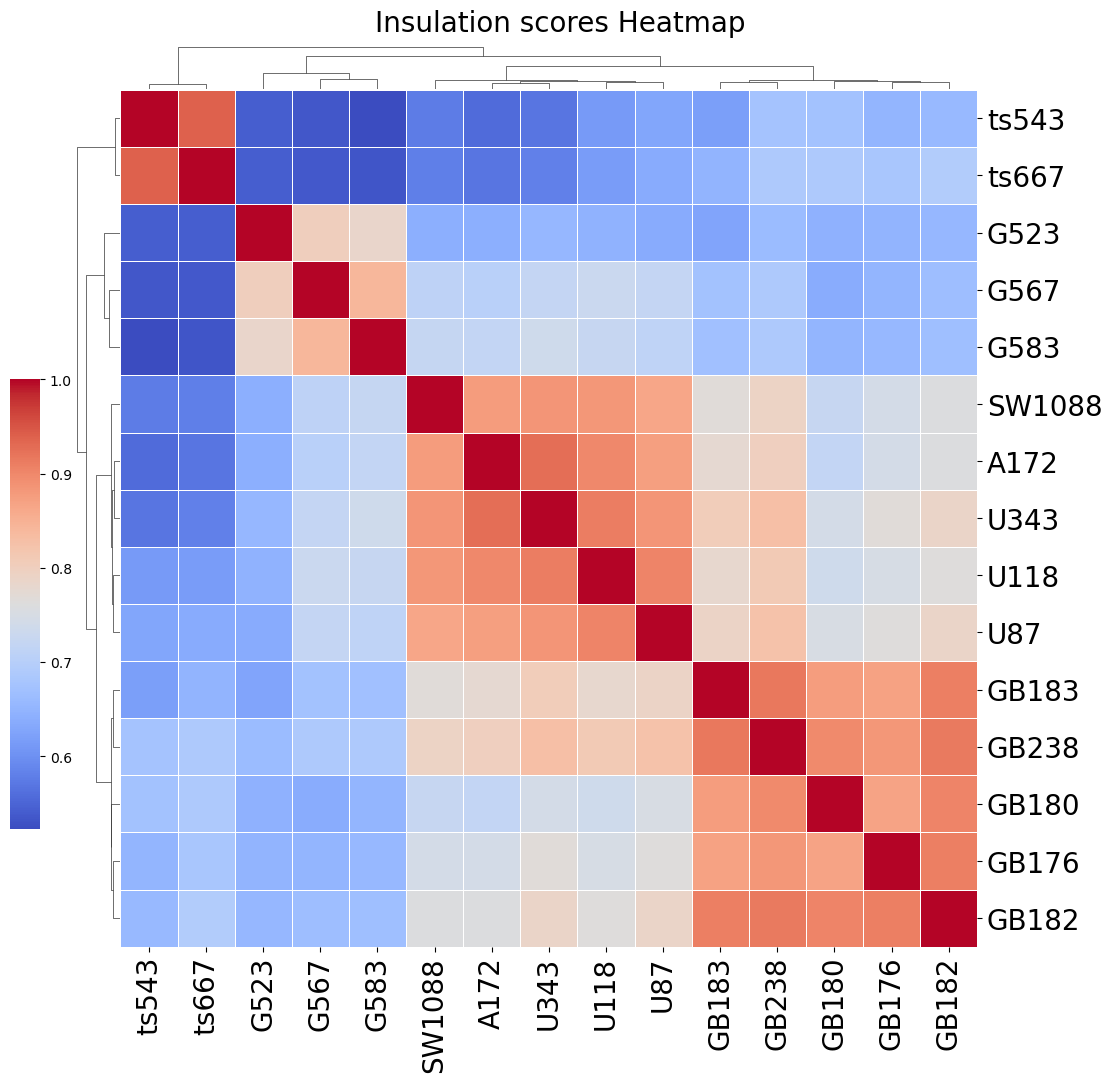

In [ ]:
all_old=pd.concat([old_nonstem_insul,old_stem_insul],axis=1)
all_old_fil=all.loc[(all_old !=0).any(axis=1),:]
# 计算样本之间的相关系数作为相似度
sample_similarity = all_old_fil.corr()

# 绘制热图
plt.figure(figsize=(8, 6))
g = sns.clustermap(sample_similarity, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5
                    ,dendrogram_ratio=(0.05, 0.05)   
                    ,cbar_pos=(-0.05, 0.2, 0.03, 0.45))
#plt.title('Insulation scores Heatmap', fontsize=16, pad=30,loc='center') 
plt.suptitle('Insulation scores Heatmap', fontsize=20, y=1.02) 
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=20)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=20)
# 显示图形
plt.show()